In [268]:
!pip install selenium

In [269]:
!pip install wordcloud

In [270]:
import re
import time
from tqdm import tqdm

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from selenium import webdriver

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from pymystem3 import Mystem
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import *
from sklearn import metrics

Работаем с размеченным датасетом. -2, -1 - сильно отрицательное, отрицательное настроение, 0 - нейтральное, 1 и 2 - положительное и сильно положительное

In [271]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [272]:
labeled_tweets = pd.read_excel('doc_comment_summary.xlsx', sheet_name = 0, header=None, index_col = False)

In [273]:
labeled_tweets

0   1
0      Но при мужчине ни одна приличная женщина не по...  -1
1      Украина это часть Руси искусственно отделенная...  -1
2      Как можно говорить об относительно небольшой к...  -1
3      1.2014.  а что они со своими поляками сделали?...   0
4      у а фильмы... Зрители любят диковинное.   у ме...   0
...                                                  ...  ..
26868  Многих заставляют. Многие сами проявляют излиш...  -1
26869  Очередной Чубайс.  ну а чего нового то? Сорос ...  -1
26870  Закон, как все предыдущие - абсолютный бред и ...   0
26871  дело которое ты делаешь сейчас - оно очень хор...   0
26872  Рядом с Токио, да, мало пальм :) Зато на Окина...   0

[26873 rows x 2 columns]

Убираем пропущенные данные

In [274]:
labeled_tweets = labeled_tweets.dropna()

In [275]:
labeled_tweets.isna().sum()

0    0
1    0
dtype: int64

Убираем некириллические символы, стоп-слова и переводим в нижний регистр

In [276]:
def clear_text(text):
    clear_text = re.sub(r'[^А-яЁё]+', ' ', text).lower()
    return " ".join(clear_text.split())

In [277]:
def clean_stop_words(text, stopwords):
    text = [word for word in text.split() if word not in stopwords]
    return " ".join(text)

In [278]:
stopwords = set(nltk_stopwords.words('russian'))

In [279]:
labeled_tweets

0   1
0      Но при мужчине ни одна приличная женщина не по...  -1
1      Украина это часть Руси искусственно отделенная...  -1
2      Как можно говорить об относительно небольшой к...  -1
3      1.2014.  а что они со своими поляками сделали?...   0
4      у а фильмы... Зрители любят диковинное.   у ме...   0
...                                                  ...  ..
26868  Многих заставляют. Многие сами проявляют излиш...  -1
26869  Очередной Чубайс.  ну а чего нового то? Сорос ...  -1
26870  Закон, как все предыдущие - абсолютный бред и ...   0
26871  дело которое ты делаешь сейчас - оно очень хор...   0
26872  Рядом с Токио, да, мало пальм :) Зато на Окина...   0

[26775 rows x 2 columns]

Задаем столбцы

In [280]:
labeled_tweets.columns = ['text', 'label']

Применяем вышеописанные функции

In [281]:
labeled_tweets['text'] = labeled_tweets['text'].apply(lambda x: clean_stop_words(clear_text(str(x)), stopwords))

<ipython-input-281-5ba17011469f>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [282]:
labeled_tweets

text label
0      мужчине одна приличная женщина пойдет лазить р...    -1
1      украина это часть руси искусственно отделенная...    -1
2      говорить относительно небольшой коррупции обра...    -1
3      своими поляками сделали русских понятно литовс...     0
4      фильмы зрители любят диковинное соседка пятом ...     0
...                                                  ...   ...
26868  многих заставляют многие сами проявляют излишн...    -1
26869  очередной чубайс нового сорос х дал исчерпываю...    -1
26870  закон предыдущие абсолютный бред нежелание реш...     0
26871  дело которое делаешь оно очень хорошее делаешь...     0
26872  рядом токио мало пальм зато окинаве омг напишу...     0

[26775 rows x 2 columns]

Просматриваем уникальные значения в стобце 'label'. В него затесались пустые или ошибочные значения

In [283]:
labeled_tweets['label'].unique()

array([-1, 0, 1, -2, 2, 'Виталия Салина', 'Арина Макковеева',
       'Yudenkova Dasha', 'GalinaPozd', 21887, 'Анна Вейдер', 22158,
       23486, 'Минченкова Елизавета ', 'Иван Мишалкин ', 'Анна Аникина',
       23523], dtype=object)

In [284]:
mis_val = ['Виталия Салина', 'Арина Макковеева',
       'Yudenkova Dasha', 'GalinaPozd', 21887, 'Анна Вейдер', 22158,
       23486, 'Минченкова Елизавета ', 'Иван Мишалкин ', 'Анна Аникина',
       23523]

In [285]:
raws = labeled_tweets.loc[labeled_tweets['label'].isin(mis_val)]

In [286]:
raws.index

Int64Index([ 3566,  4240,  4453,  5725,  6589,  8545, 10224, 10520, 11155,
            15325, 15786, 16437, 17474, 18462, 18496, 19641, 20876, 20930,
            23636, 24906, 25228, 25864, 26375],
           dtype='int64')

Убираем пустые значения из стобца

In [287]:
labeled_tweets = labeled_tweets.drop(raws.index, axis=0)

Также в стобце 'label' слишком много уровней эмоциональной окраски -2, -1, 0, 1, 2. Сократим до 0 и 1, где 1 - это положительное настроение, а 0 - отрицательное.

In [288]:
labeled_tweets['label'] = labeled_tweets['label'].astype('int')

In [289]:
labeled_tweets['label'] = labeled_tweets['label'].replace(-2, -1)

In [290]:
labeled_tweets['label'] = labeled_tweets['label'].replace([0,2], 1)

In [291]:
labeled_tweets['label'] = labeled_tweets['label'].replace(-1, 0)

In [292]:
labeled_tweets['label'].unique()

array([0, 1])

Разделяем на тренировочный и проверочный наборы

In [293]:
train, test = train_test_split(
  											labeled_tweets,
                        test_size = 0.2,
                        random_state = 12348,
                       )

Для векторизации слов применяем TF-IDF. Самым редко встречаемым словам выдаем бОльший вес, часто встречаемым - маленький вес

In [294]:
counter_idf = TfidfVectorizer(ngram_range=(1,1))

In [295]:
train_tf_idf = counter_idf.fit_transform(train['text'])

In [296]:
test_tf_idf = counter_idf.transform(test['text'])

In [297]:
display(test_tf_idf.shape)
display(train_tf_idf.shape)

(5351, 156109)

(21401, 156109)

Берем логистическую регрессию

In [298]:
model_lr = LogisticRegression(solver = 'lbfgs',
                                    random_state = 12345,
                                    max_iter= 10000,
                                    n_jobs= -1)

In [299]:
model_lr.fit(train_tf_idf, train['label'])

LogisticRegression(max_iter=10000, n_jobs=-1, random_state=12345)

Берем predict_proba для вычисления точных(сырых, без классификации) вероятностей.

In [300]:
pred_proba = model_lr.predict_proba(test_tf_idf)

Получаем вероятность того, будет ли комментарий отрицательным и вероятность того, будет ли комментарий положительным.

In [301]:
pred_proba

array([[0.26416438, 0.73583562],
       [0.29833438, 0.70166562],
       [0.4538002 , 0.5461998 ],
       ...,
       [0.43206587, 0.56793413],
       [0.44483374, 0.55516626],
       [0.29907933, 0.70092067]])

Строим ROC кривую

In [302]:
fpr_base, tpr_base, _ = roc_curve(test['label'], pred_proba[:, 1])
roc_auc_base = auc(fpr_base, tpr_base)

In [303]:
fig = make_subplots(1,1,
                    subplot_titles = ["Receiver operating characteristic"],
                    x_title="False Positive Rate",
                    y_title = "True Positive Rate"
                   )

Получаем ROC кривую. Видим небольшой охват верхнего левого угла - значит классификация неплохая.

In [304]:
fig.add_trace(go.Scatter(
    x = fpr_base,
    y = tpr_base,
    name = "ROC base (area = %0.3f)" % roc_auc_base,
    ))

Выведем матрицу ошибок. По строкам - действительные значения, по столбцам - предсказанные

In [305]:
confusion_matrix(test['label'],
                 (pred_proba[:, 1] > 0.5).astype('float'),
                 normalize='true',
                )

array([[0.46574691, 0.53425309],
       [0.18590335, 0.81409665]])

Вычисляем важность слов

In [306]:
weights = pd.DataFrame({'words': counter_idf.get_feature_names_out(),
                        'weights': model_lr.coef_.flatten()})
weights_min = weights.sort_values(by= 'weights')
weights_max = weights.sort_values(by= 'weights', ascending = False)

In [308]:
weights_max = weights_max[:100]
weights_max

words   weights
129084        спасибо  3.711678
63281              мм  1.980189
92547          победы  1.782906
102024     праздником  1.775019
68935       насколько  1.758681
...               ...       ...
123950         сказка  0.874069
13630             вид  0.872463
70812          недель  0.870338
19231   выздоровления  0.869735
123430         сильно  0.869070

[100 rows x 2 columns]

Строим облако положительных тэгов

In [341]:
wordcloud_positive = WordCloud(background_color="white",
                               colormap = 'Blues',
                               max_words=200,
                               mask=None,
                                width=1600,
                               height=1600)\
                        .generate_from_frequencies(
                            dict(weights_max.values))

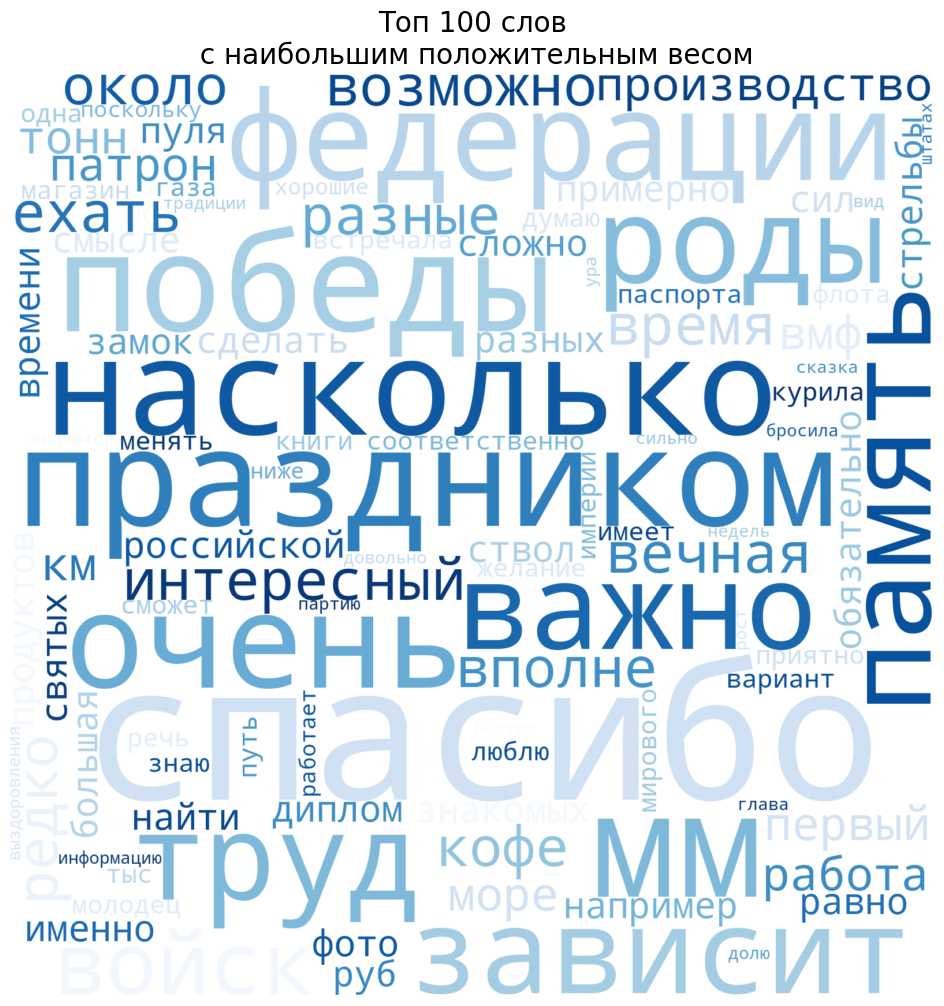

In [343]:
fig, ax = plt.subplots(1, 1, figsize = (20, 12))


ax.imshow(wordcloud_positive, interpolation='bilinear')

ax.set_title('Топ ' +\
                str(weights_max.shape[0]) +\
                ' слов\n с наибольшим положительным весом',
               fontsize = 20
               )

ax.axis("off")

plt.show()

Строим график размерности признакого пространства

In [311]:
fig = make_subplots(1,1)

In [312]:
fig.add_trace(go.Histogram(
    x = weights.query('weights != 0')['weights'],
    #histnorm = 'probability',
    opacity = 0.5,
    showlegend = False
))

fig.add_trace(go.Histogram(
    x = weights.query('weights > 0.25 or weights < -0.25')['weights'],
    #histnorm = 'probability',
    opacity = 0.5,
    showlegend = False
))

fig.update_layout(
    height = 600,
    width = 800,
    xaxis_showgrid=False,
    xaxis_zeroline=False,
    template = 'plotly_dark',
    font_color = 'rgba(212, 210, 210, 1)'

)

Слова с весом близким к нулю сосредоточены в интервале -0.1 до 0.1 Так как они особо никак не влияют на конечную сумму в уравнении с коэффициентами, их можно отбросить.

In [313]:
vocab = weights.query('weights > 0.1 or weights < -0.1')['words']

In [314]:
vocab

0                  аа
2                аааа
4              аааааа
9         ааааааааааа
18             аалюты
             ...     
156078          ёмкий
156085            ёпт
156099         ёсиаки
156100        ёсицунэ
156105          ёшкин
Name: words, Length: 43480, dtype: object

Снова обучаем модель

In [315]:
count_idf = TfidfVectorizer(vocabulary=vocab,
                            ngram_range=(1,1))

In [316]:
tf_idf_train = count_idf.fit_transform(train['text'])
tf_idf_test = count_idf.transform(test['text'])

In [317]:
display(tf_idf_test.shape)
display(tf_idf_train.shape)

(5351, 43480)

(21401, 43480)

In [318]:
model_lr.fit(tf_idf_train, train['label'])

LogisticRegression(max_iter=10000, n_jobs=-1, random_state=12345)

In [319]:
pred_proba_2 = model_lr.predict_proba(tf_idf_test)

In [320]:
fpr_base_1, tpr_base_1, _ = roc_curve(test['label'], pred_proba_2[:, 1])
roc_auc_base_1 = auc(fpr_base_1, tpr_base_1)

In [321]:
fig = make_subplots(1,1,
                    subplot_titles = ["Receiver operating characteristic"],
                    x_title="False Positive Rate",
                    y_title = "True Positive Rate"
                   )

Строим ROC кривую

In [322]:
fig.add_trace(go.Scatter(
    x = fpr_base,
    y = tpr_base,
    fill = 'tozeroy',
    name = "ROC curve (area = %0.3f)" % roc_auc_base,
    ))
fig.add_trace(go.Scatter(
    x = fpr_base_1,
    y = tpr_base_1,
    fill = 'tozeroy',
    name = "Less dimensity ROC curve (area = %0.3f)" % roc_auc_base_1,
    ))


Площадь под ROC кривой стала меньше - потеряли 0,02 в качестве, но существенно уменьшили размерность

Предскажем оценку настроения для неразмеченных данных

In [323]:
comments_putin = pd.read_csv('comments_putin.csv', index_col=0)
comments_shulman = pd.read_csv('comments_shulman.csv', index_col=0)

In [324]:
comments_putin['text_clear'] = comments_putin['comment'].apply(lambda x: clean_stop_words(clear_text(str(x)), stopwords))

comments_shulman['text_clear'] = comments_shulman['comment'].apply(lambda x: clean_stop_words(clear_text(str(x)), stopwords))

In [325]:
comments_putin

comment  \
0                         Народ тебя никогда не забудет   
1     Желаю путину всего того , что он сделал для на...   
2     Зашёл сюда не послушать,  а почитать! Сильно у...   
3     2046 год. Путин: "Год был непростым, прошу отн...   
4     Я ждал что он скажет "уходящий год был непрост...   
...                                                 ...   
3339                            Лучший президент России   
3340                 Благослови навеки Путина и Россию!   
3341  В коментах вижувсе недовольные. Так идите рабо...   
3342                       Сами лучи президента России.   
3343                                                NaN   

                                             text_clear  
0                                         народ забудет  
1             желаю путину сделал народа очень искренне  
2         зашёл сюда послушать почитать сильно улыбнуло  
3     год путин год непростым прошу отнестись понима...  
4                    ждал скажет уходящий год непростым  
...                                                 ...  
3339                            лучший президент россии  
3340                    благослови навеки путина россию  
3341  коментах вижувсе недовольные идите работать ту...  
3342                        сами лучи президента россии  
3343                                                     

[3344 rows x 2 columns]

In [326]:
shulman_counter = CountVectorizer(ngram_range=(1, 1))
putin_counter = CountVectorizer(ngram_range=(1, 1))

In [327]:
shulman_counter.fit_transform(comments_shulman['text_clear'])
putin_counter.fit_transform(comments_putin['text_clear'])

<3344x5238 sparse matrix of type '<class 'numpy.int64'>'
	with 21518 stored elements in Compressed Sparse Row format>

In [328]:
for _ in range(5):

    source = comments_putin.sample(n=1)
    text_clear = source['text_clear'].values[0]
    text = source['comment'].values[0]

    print(text)

    tf_idf_text = count_idf.transform([text_clear])

    toxic_proba = model_lr.predict_proba(tf_idf_text)

    print('Вероятность негатива: ', toxic_proba[:, 0])
    print()

В этом году БОГ дасть бледая моль  уйдет
Вероятность негатива:  [0.23143542]

Давайте помечтаем
Вероятность негатива:  [0.39347542]

Поздравляем россиян с Новым 2022 Годом ! Желаем всего доброго и светлого в наступившем году !! Мира и процветания !!!
Вероятность негатива:  [0.26122205]

От тебя все проблемы
Вероятность негатива:  [0.35618329]

Я чего, один тут Путина люблю? Где остальные боты??? Бухают чтоль? 
RT -- отключайте комментарии, всё ясно уже!
Вероятность негатива:  [0.45464128]



In [329]:
for _ in range(5):

    source = comments_shulman.sample(n=1)
    text_clear = source['text_clear'].values[0]
    text = source['comment'].values[0]

    print(text)

    tf_idf_text = count_idf.transform([text_clear])

    toxic_proba = model_lr.predict_proba(tf_idf_text)

    print('Вероятность негатива: ', toxic_proba[:, 0])
    print()

Екатерина, будьте моим Президентом!
Вероятность негатива:  [0.40253378]

Спасибо за поздравления! Всех с Новым годом!
Вероятность негатива:  [0.14194042]

Приятно смотреть на Вас...    слушать и думать.....    Спасибо!!!!
Вероятность негатива:  [0.14343011]

Самая лучшая 
Вероятность негатива:  [0.35618329]

Екатерина Михайловна, спасибо огромное! Вас так приятно слушать и смотреть ! С Праздником Друзья! С Новым 2022 годом!!
Вероятность негатива:  [0.14885864]



Здесь по матрице ошибок вычисляется наилучший порог классификации. Берется weight в сторону отрицательного(негативного ответа), затем для каждого threshold(значения порога) строится матрица ошибок, там каждый элемент на главной диагонали(истино положительный и истино негативный) умножаются на weight и складываются. Ищем наибольшую полученную сумму и какое значение threshold ему соответствует.

Функция в которой вычисляем наилучший порог

In [330]:
scores = {}

weight = 0.55

for threshold in np.linspace(0, 1, 100):

    matrix = confusion_matrix(test['label'],
                 (pred_proba[:, 0] <  threshold).astype('float'),
                 normalize='true',
                )

    score = matrix[0,0] * weight + matrix[1,1] * (1 - weight)
    scores[threshold] = score

Поменяли разметку отрицательных комментариев с -1 на 0. Сделано для того, чтобы массив сформированной строкой (pred_proba [:, 0] <  threshold).astype('float') можно было сопоставить с массивом test['label'] по значениям. (pred_proba[:, 0] <  threshold).astype('float') данная строка формирует массив 1 и 0. 1 это если значения из первого столбца pred_proba меньше значений из threshold, 0 - наоборот.

In [331]:
pd.DataFrame({'true_score':scores.values(),
             'threshold':scores.keys()},
             ).sort_values(by = 'true_score', ascending = False).head()

true_score  threshold
34    0.685427   0.343434
33    0.684013   0.333333
32    0.681367   0.323232
35    0.680270   0.353535
31    0.679414   0.313131

Получаем вероятность истинно-негативного комментария ~81%
Вероятность истинно-отрицательного комментария ~53%
Ложно-отрицательного ~47%
Ложно-положительного ~19%

pred[:, 0] - дает нам вероятность отрицательных комментариев

In [345]:
matrix = confusion_matrix(test['label'],
                 (pred_proba[:, 0] <  0.343434).astype('int'),
                 normalize='true',
                )
matrix

array([[0.81208373, 0.18791627],
       [0.46937519, 0.53062481]])

Оценим все комментарии обоих видео

In [333]:
putin_tf_idf = count_idf.transform(comments_putin['text_clear'])
shulman_tf_idf = count_idf.transform(comments_shulman['text_clear'])

putin_negative_proba = model_lr.predict_proba(putin_tf_idf)
shulman_negative_proba = model_lr.predict_proba(shulman_tf_idf)

comments_putin['negative_proba'] = putin_negative_proba[:, 0]
comments_shulman['negative_proba'] = shulman_negative_proba[:, 0]

In [334]:
putin_share_neg = (comments_putin['negative_proba'] > 0.343434).sum() / comments_putin.shape[0]
putin_share_neg

0.7296650717703349

In [335]:
shulman_share_neg = (comments_shulman['negative_proba'] > 0.343434).sum() / comments_shulman.shape[0]
shulman_share_neg

0.3646850044365572